## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256,128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu")(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu")(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.3,0.5]
redice_lr_patient = [1,5]

In [10]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0724 19:12:46.250419  1092 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0724 19:12:46.391601  1092 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.30, reduce_patient: 1


W0724 19:12:46.697989  1092 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0724 19:12:46.722498  1092 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 822,410
Trainable params: 821,642
Non-trainable params: 768
_________________________________________________________________


W0724 19:12:46.913539  1092 deprecation.py:323] From C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 176us/step - loss: 2.1670 - acc: 0.2742 - val_loss: 2.0750 - val_acc: 0.3167
Epoch 2/25
50000/50000 [==============================] - 7s 141us/step - loss: 1.7569 - acc: 0.3865 - val_loss: 1.7687 - val_acc: 0.3842
Epoch 3/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.6559 - acc: 0.4203 - val_loss: 1.6686 - val_acc: 0.4111
Epoch 4/25
50000/50000 [==============================] - 7s 141us/step - loss: 1.5954 - acc: 0.4418 - val_loss: 1.6334 - val_acc: 0.4230
Epoch 5/25
50000/50000 [==============================] - 7s 140us/step - loss: 1.5527 - acc: 0.4566 - val_loss: 1.6148 - val_acc: 0.4295
Epoch 6/25
50000/50000 [==============================] - 7s 141us/step - loss: 1.5184 - acc: 0.4692 - val_loss: 1.5773 - val_acc: 0.4431
Epoch 7/25
50000/50000 [==============================] - 7s 140us/step - loss: 1.4879 - acc: 0.4800 - val_loss: 1.5601 - 

50000/50000 [==============================] - 7s 143us/step - loss: 1.8415 - acc: 0.3586 - val_loss: 1.8810 - val_acc: 0.3459
Epoch 25/25
50000/50000 [==============================] - 7s 140us/step - loss: 1.8334 - acc: 0.3624 - val_loss: 1.8738 - val_acc: 0.3489
Numbers of exp: 2, reduce_factor: 0.50, reduce_patient: 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               786688    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalizat

50000/50000 [==============================] - 7s 144us/step - loss: 1.9488 - acc: 0.3230 - val_loss: 1.9793 - val_acc: 0.3192
Epoch 16/25
50000/50000 [==============================] - 7s 141us/step - loss: 1.9343 - acc: 0.3282 - val_loss: 1.9653 - val_acc: 0.3227
Epoch 17/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.9220 - acc: 0.3318 - val_loss: 1.9530 - val_acc: 0.3267
Epoch 18/25
50000/50000 [==============================] - 7s 144us/step - loss: 1.9097 - acc: 0.3350 - val_loss: 1.9404 - val_acc: 0.3310
Epoch 19/25
50000/50000 [==============================] - 7s 141us/step - loss: 1.8982 - acc: 0.3392 - val_loss: 1.9302 - val_acc: 0.3343
Epoch 20/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.8879 - acc: 0.3419 - val_loss: 1.9197 - val_acc: 0.3366
Epoch 21/25
50000/50000 [==============================] - 7s 143us/step - loss: 1.8778 - acc: 0.3453 - val_loss: 1.9100 - val_acc: 0.3408
Epoch 22/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 183us/step - loss: 2.9468 - acc: 0.0967 - val_loss: 2.9542 - val_acc: 0.0958
Epoch 2/25
50000/50000 [==============================] - 7s 142us/step - loss: 2.9473 - acc: 0.0963 - val_loss: 2.9543 - val_acc: 0.0957
Epoch 3/25
50000/50000 [==============================] - 8s 151us/step - loss: 2.9469 - acc: 0.0973 - val_loss: 2.9540 - val_acc: 0.0956
Epoch 4/25
50000/50000 [==============================] - 7s 148us/step - loss: 2.9459 - acc: 0.0968 - val_loss: 2.9540 - val_acc: 0.0957
Epoch 5/25
50000/50000 [==============================] - 8s 151us/step - loss: 2.9468 - acc: 0.0970 - val_loss: 2.9540 - val_acc: 0.0957
Epoch 6/25
50000/50000 [==============================] - 8s 153us/step - loss: 2.9473 - acc: 0.0958 - val_loss: 2.9541 - val_acc: 0.0956
Epoch 7/25
50000/50000 [==============================] - 9s 176us/step - loss: 2.9464 - acc: 0.0964 - val_loss: 2.9539 - 

50000/50000 [==============================] - 7s 138us/step - loss: 2.9981 - acc: 0.1139 - val_loss: 2.9976 - val_acc: 0.1156
Epoch 23/25
50000/50000 [==============================] - 8s 157us/step - loss: 2.9980 - acc: 0.1137 - val_loss: 2.9976 - val_acc: 0.1155
Epoch 24/25
50000/50000 [==============================] - 9s 183us/step - loss: 2.9976 - acc: 0.1140 - val_loss: 2.9976 - val_acc: 0.1154
Epoch 25/25
50000/50000 [==============================] - 7s 140us/step - loss: 2.9977 - acc: 0.1142 - val_loss: 2.9977 - val_acc: 0.1155
Numbers of exp: 7, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               786688    
_________________________________________________________________
ba

50000/50000 [==============================] - 8s 156us/step - loss: 1.1890 - acc: 0.5906 - val_loss: 1.3941 - val_acc: 0.5040
Epoch 13/25
50000/50000 [==============================] - 7s 145us/step - loss: 1.1800 - acc: 0.5940 - val_loss: 1.3945 - val_acc: 0.5073

Epoch 00013: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
Epoch 14/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.1676 - acc: 0.5987 - val_loss: 1.3660 - val_acc: 0.5193
Epoch 15/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.1641 - acc: 0.6017 - val_loss: 1.3646 - val_acc: 0.5177
Epoch 16/25
50000/50000 [==============================] - 8s 153us/step - loss: 1.1611 - acc: 0.6017 - val_loss: 1.3623 - val_acc: 0.5187
Epoch 17/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.1585 - acc: 0.6029 - val_loss: 1.3610 - val_acc: 0.5213
Epoch 18/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.1566 - acc: 0.

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 10s 201us/step - loss: 3.0712 - acc: 0.0890 - val_loss: 3.0475 - val_acc: 0.0935
Epoch 2/25
50000/50000 [==============================] - 7s 148us/step - loss: 3.0687 - acc: 0.0897 - val_loss: 3.0449 - val_acc: 0.0940
Epoch 3/25
50000/50000 [==============================] - 7s 148us/step - loss: 3.0668 - acc: 0.0897 - val_loss: 3.0419 - val_acc: 0.0940
Epoch 4/25
50000/50000 [==============================] - 7s 148us/step - loss: 3.0640 - acc: 0.0897 - val_loss: 3.0394 - val_acc: 0.0941
Epoch 5/25
50000/50000 [==============================] - 7s 147us/step - loss: 3.0613 - acc: 0.0907 - val_loss: 3.0366 - val_acc: 0.0942
Epoch 6/25
50000/50000 [==============================] - 7s 148us/step - loss: 3.0594 - acc: 0.0902 - val_loss: 3.0340 - val_acc: 0.0944
Epoch 7/25
50000/50000 [==============================] - 7s 147us/step - loss: 3.0570 - acc: 0.0905 - val_loss: 3.0314 -

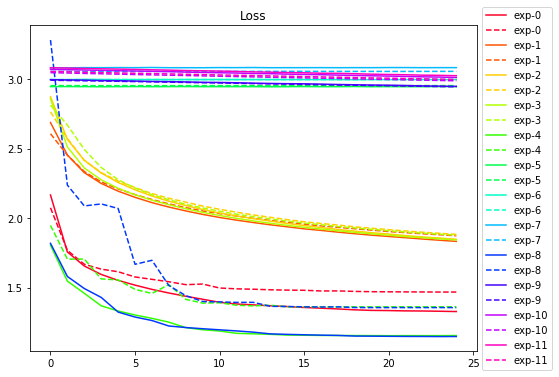

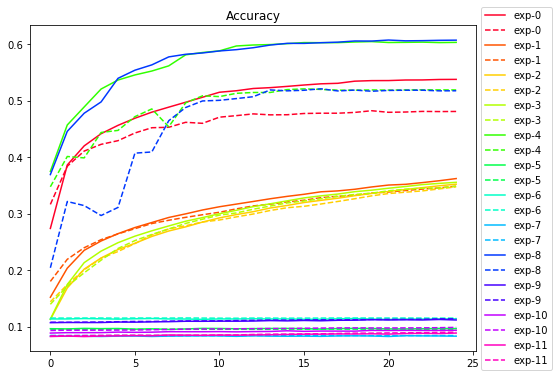

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()